In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from pycaret.classification import ClassificationExperiment
from pycaret.classification import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [2]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [3]:
datasheet = datasheet.drop([
    'vendor_id', 
    'rating', 
    'country', 
    'pet_size',
    're_buy'
], axis=1)
datasheet.head()

,product_category,sales,price,VAP,pet_type
product_id,,,,,
5040,Equipment,123,7293,0,fish
4567,Toys,61,9304,1,cat
4237,Toys,218,8180,0,hamster
4364,Snack,69,18559,1,dog
4184,Supplements,138,10283,1,dog


### Plotting for analysis

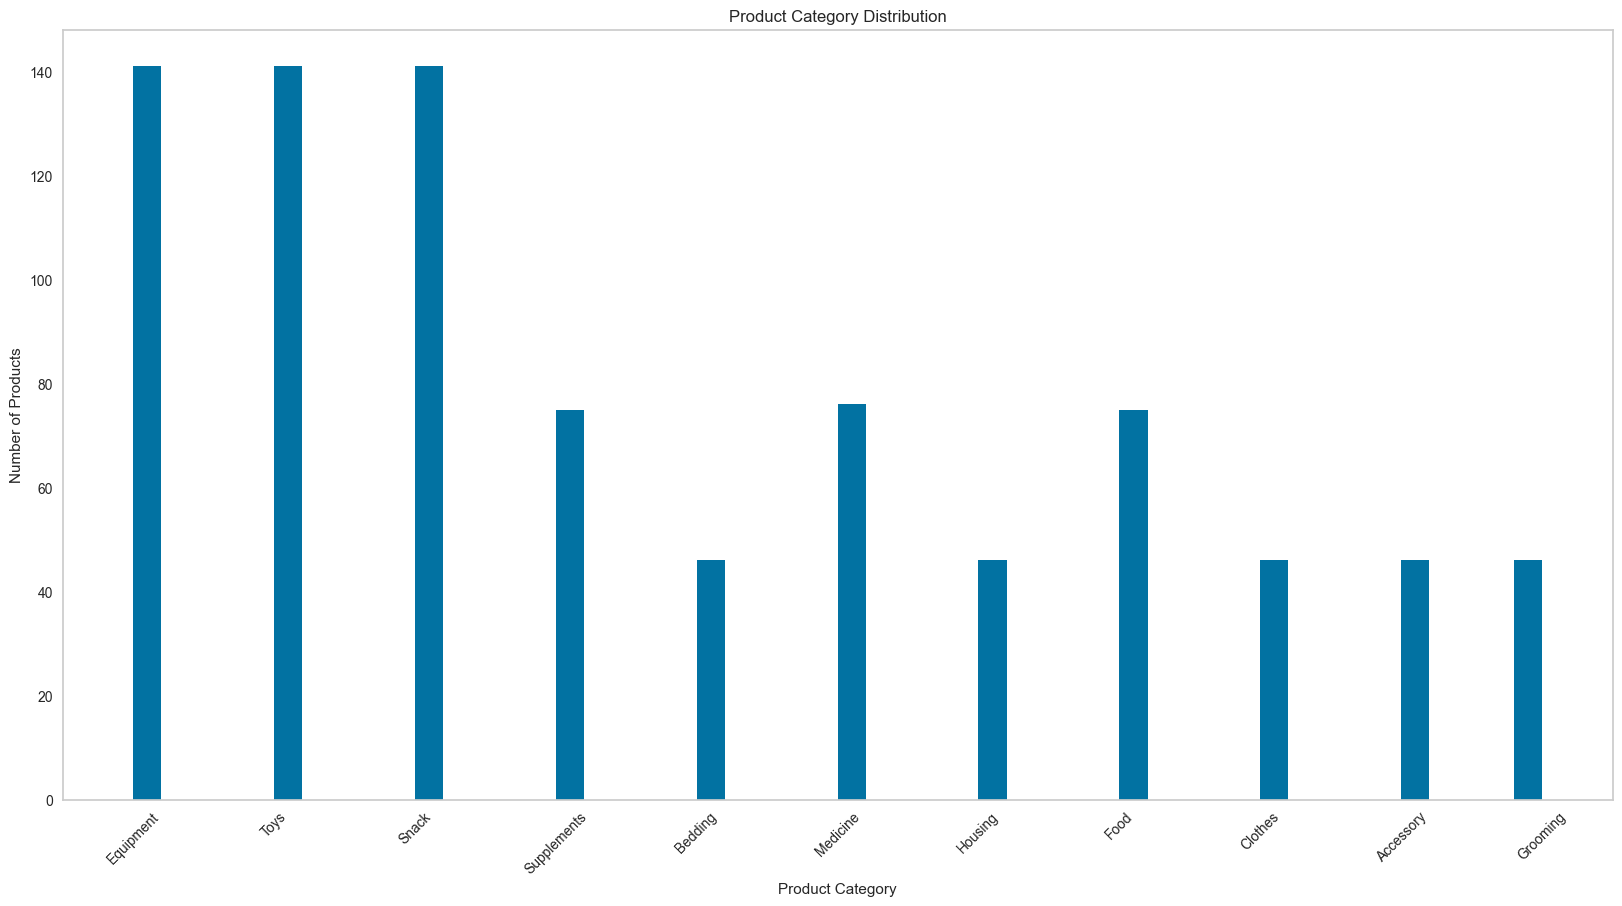

In [4]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

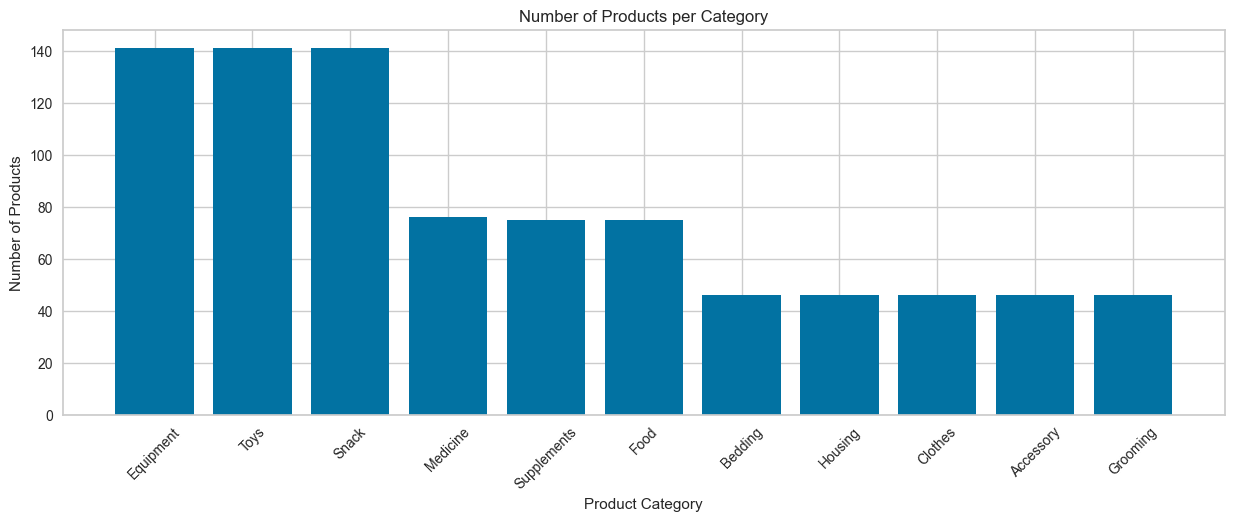

In [5]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

# Pre-processing

In [6]:
org_product_category = datasheet['product_category'].to_list()
product_category_uni = datasheet['product_category'].unique()
product_category_uni_code = [i for i in range(len(product_category_uni))]
for i in range(len(product_category_uni)):  print(f"[{product_category_uni[i]}]\t->\t[{product_category_uni_code[i]}]")

product_category = []
for i in range(len(org_product_category)):
    for j in range(len(product_category_uni)):
        if org_product_category[i] == product_category_uni[j]:
            product_category.append(product_category_uni_code[j])

datasheet['product_category'] = product_category

[Equipment]	->	[0]
[Toys]	->	[1]
[Snack]	->	[2]
[Supplements]	->	[3]
[Bedding]	->	[4]
[Medicine]	->	[5]
[Housing]	->	[6]
[Food]	->	[7]
[Clothes]	->	[8]
[Accessory]	->	[9]
[Grooming]	->	[10]


In [7]:
org_pet_type = datasheet['pet_type'].to_list()
pet_type_uni = datasheet['pet_type'].unique()
pet_type_uni_code = [i for i in range(len(pet_type_uni))]
for i in range(len(pet_type_uni)):  print(f"[{pet_type_uni_code[i]}]\t->\t{pet_type_uni[i]}")

pet_type = []
for i in range(len(org_pet_type)):
    for j in range(len(pet_type_uni)):
        if org_pet_type[i] == pet_type_uni[j]:
            pet_type.append(pet_type_uni_code[j])

datasheet['pet_type'] = pet_type

[0]	->	fish
[1]	->	cat
[2]	->	hamster
[3]	->	dog
[4]	->	bird
[5]	->	rabbit


In [8]:
datasheet.head()

,product_category,sales,price,VAP,pet_type
product_id,,,,,
5040,0,123,7293,0,0
4567,1,61,9304,1,1
4237,1,218,8180,0,2
4364,2,69,18559,1,3
4184,3,138,10283,1,3


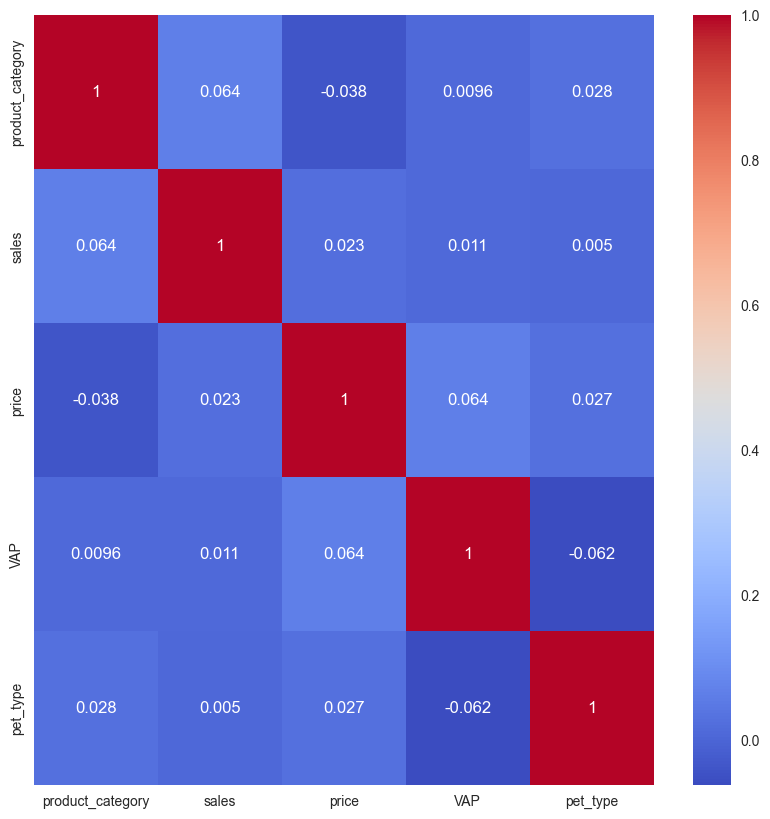

In [9]:
corr = datasheet.corr()
corr.style.background_gradient(cmap='coolwarm')

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

<Figure size 1000x1000 with 0 Axes>

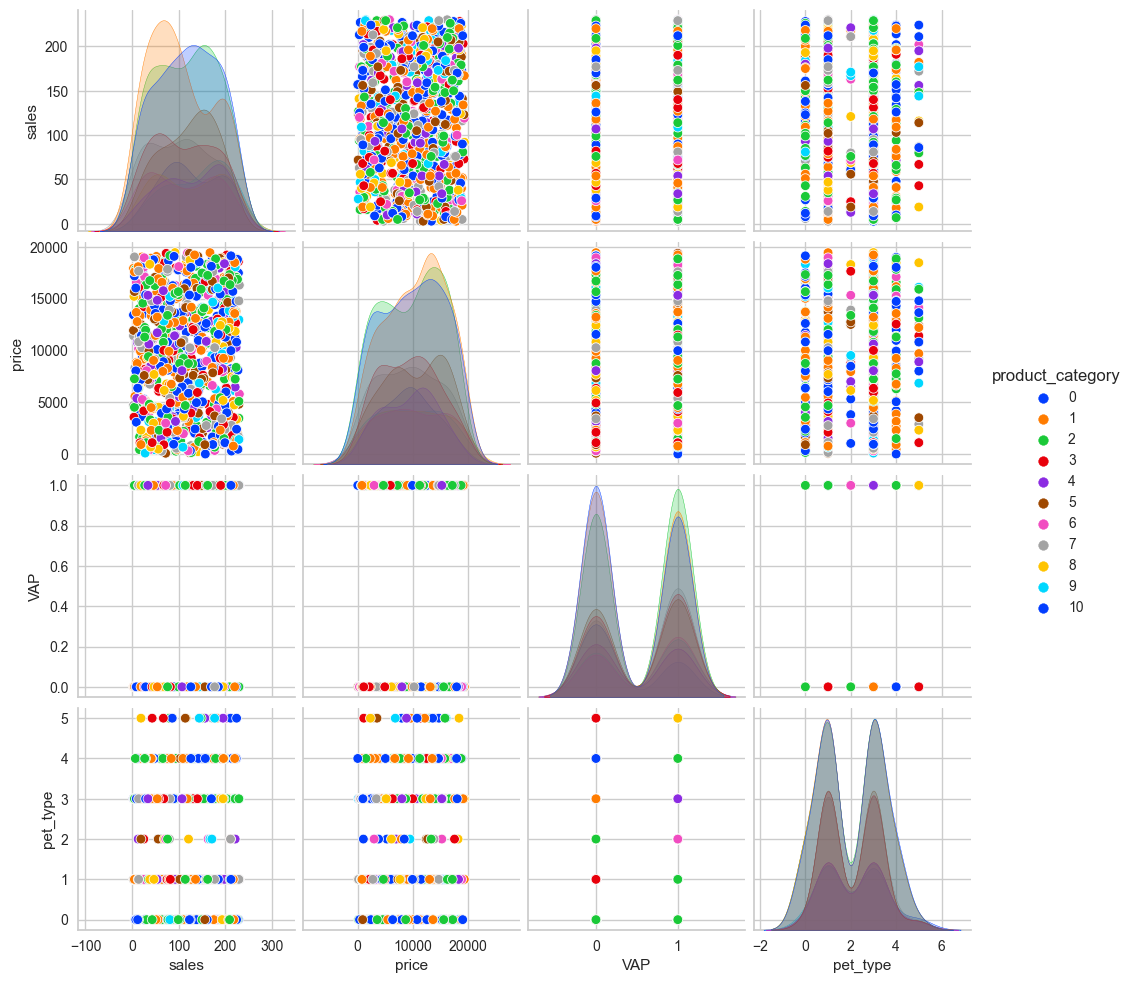

In [10]:
plt.figure(figsize=(10, 10))
sns.pairplot(datasheet, hue='product_category', palette='bright')
plt.show()

# Train, Test(Validation) Split

In [11]:
target = "product_category"

In [12]:
y_data = datasheet[target].to_numpy()
X_data = datasheet.drop([target], axis=1).to_numpy()

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 4)
y_data shape: (879,)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42, shuffle=True, stratify=y_data)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (439, 4)
y_train: (439,)
X_test: (440, 4)
y_test: (440,)


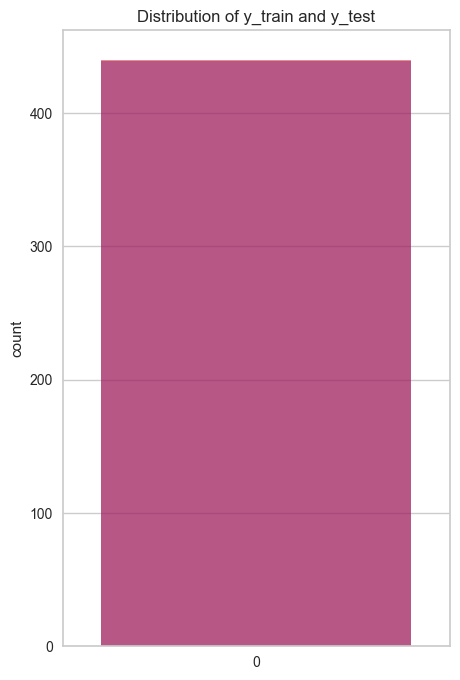

In [28]:
# X_train, y_train, X_test, y_test distribution plot
plt.figure(figsize=(5, 8))
plt.title('Distribution of y_train and y_test')
sns.countplot(y_train, color='blue', label='train', alpha=0.5)
sns.countplot(y_test, color='red', label='test', alpha=0.5)
plt.show()

# autoML

In [29]:
s = setup(datasheet, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 5)"
4,Transformed data shape,"(879, 5)"
5,Transformed train set shape,"(615, 5)"
6,Transformed test set shape,"(264, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [30]:
exp = ClassificationExperiment()
exp.setup(data=datasheet, target=target)

,Description,Value
0,Session id,1028
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 5)"
4,Transformed data shape,"(879, 5)"
5,Transformed train set shape,"(615, 5)"
6,Transformed test set shape,"(264, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [31]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.1628,0.5016,0.1628,0.0816,0.1056,0.0024,0.0012,0.0570
knn,K Neighbors Classifier,0.1626,0.5017,0.1626,0.1100,0.1240,0.0218,0.0230,0.0600
rf,Random Forest Classifier,0.1626,0.5383,0.1626,0.1448,0.1498,0.0454,0.0459,0.0890
ridge,Ridge Classifier,0.1578,0.0000,0.1578,0.0797,0.1043,-0.0038,-0.0042,0.0310
et,Extra Trees Classifier,0.1578,0.5431,0.1578,0.1531,0.1493,0.0440,0.0444,0.0810
dummy,Dummy Classifier,0.1578,0.5000,0.1578,0.0250,0.0431,0.0000,0.0000,0.0330
nb,Naive Bayes,0.1562,0.5037,0.1562,0.0821,0.1052,-0.0043,-0.0050,0.0380
lda,Linear Discriminant Analysis,0.1561,0.4928,0.1561,0.0860,0.1050,-0.0051,-0.0057,0.0360
qda,Quadratic Discriminant Analysis,0.1481,0.4996,0.1481,0.0982,0.1097,-0.0054,-0.0061,0.0470
lightgbm,Light Gradient Boosting Machine,0.1368,0.5204,0.1368,0.1300,0.1289,0.0125,0.0127,0.1210


# Random Forest Classification

In [32]:
classifier = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=42, verbose=1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

r2_score = r2_score(y_test, y_pred)
print("R2 Score: ", r2_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


MSE Loss:  17.35681818181818


TypeError: 'numpy.float64' object is not callable

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.18      0.16        71
           1       0.18      0.23      0.20        71
           2       0.17      0.25      0.20        71
           3       0.09      0.05      0.07        37
           4       0.00      0.00      0.00        23
           5       0.03      0.03      0.03        38
           6       0.00      0.00      0.00        23
           7       0.07      0.05      0.06        37
           8       0.15      0.13      0.14        23
           9       0.07      0.04      0.05        23
          10       0.00      0.00      0.00        23

    accuracy                           0.13       440
   macro avg       0.08      0.09      0.08       440
weighted avg       0.11      0.13      0.11       440



In [34]:
y_pred_train = classifier.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87        70
           1       0.94      0.93      0.94        70
           2       0.85      0.94      0.89        70
           3       0.97      0.89      0.93        38
           4       1.00      0.70      0.82        23
           5       0.97      0.89      0.93        38
           6       1.00      0.91      0.95        23
           7       0.92      0.92      0.92        38
           8       0.95      0.91      0.93        23
           9       1.00      0.91      0.95        23
          10       0.95      0.91      0.93        23

    accuracy                           0.91       439
   macro avg       0.94      0.90      0.92       439
weighted avg       0.92      0.91      0.91       439



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


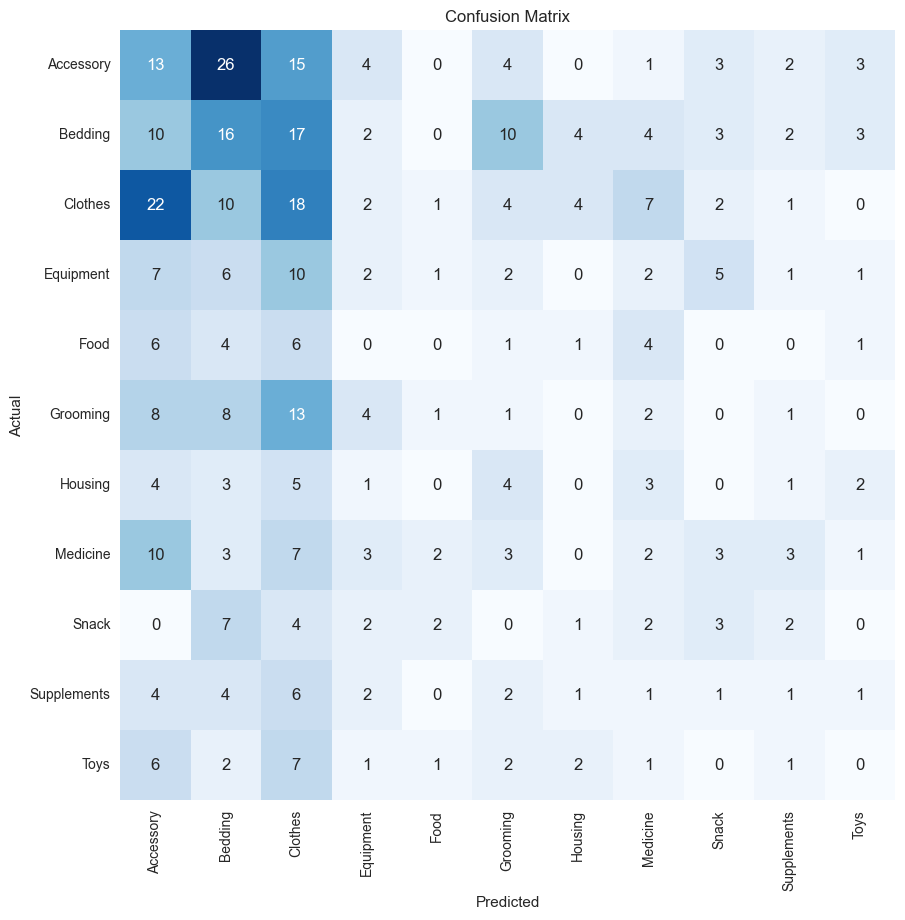

In [35]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

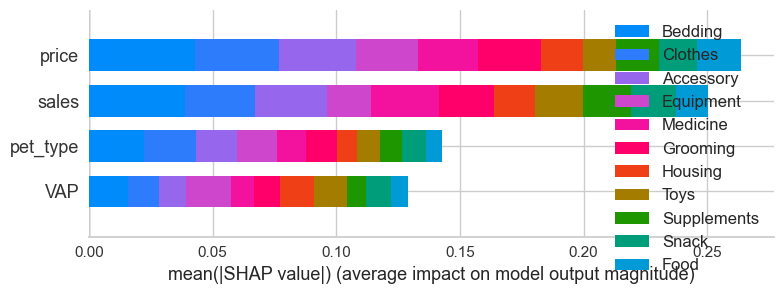

In [ ]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Decision Tree Classification

In [ ]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

MSE Loss:  19.517045454545453


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Accessory       0.08      0.07      0.08        29
     Bedding       0.29      0.32      0.31        28
     Clothes       0.23      0.21      0.22        29
   Equipment       0.06      0.07      0.06        15
        Food       0.00      0.00      0.00         9
    Grooming       0.18      0.13      0.15        15
     Housing       0.00      0.00      0.00         9
    Medicine       0.22      0.13      0.17        15
       Snack       0.00      0.00      0.00         9
 Supplements       0.20      0.11      0.14         9
        Toys       0.00      0.00      0.00         9

    accuracy                           0.13       176
   macro avg       0.12      0.09      0.10       176
weighted avg       0.15      0.13      0.14       176



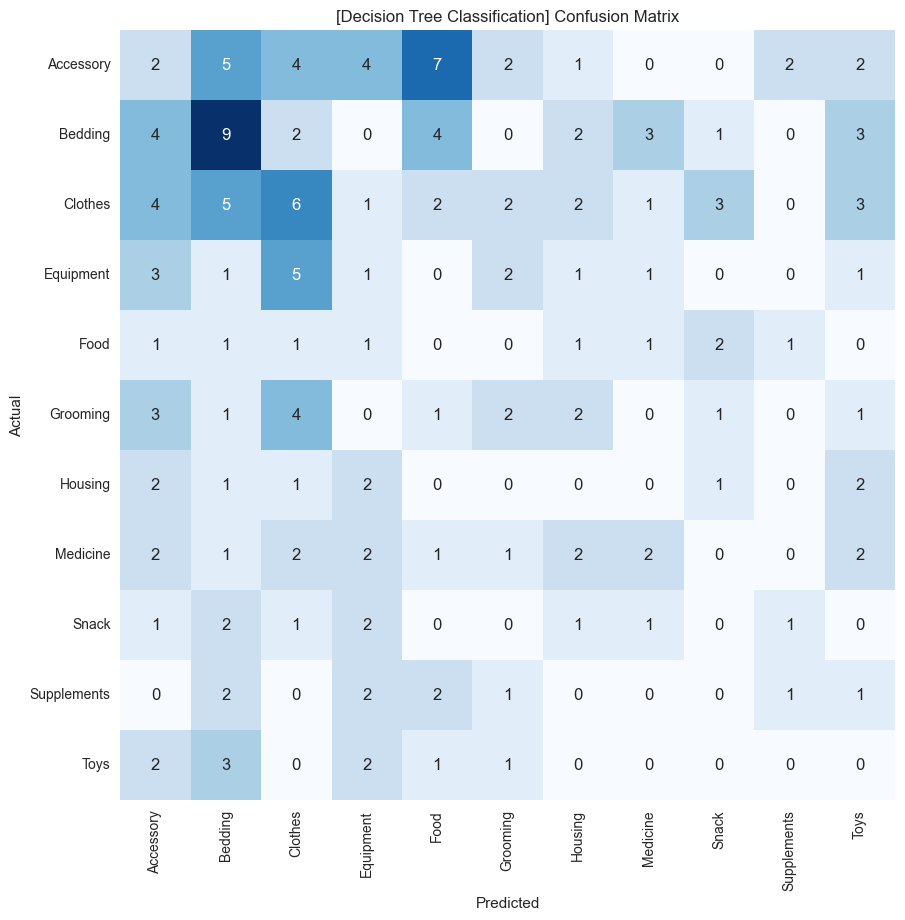

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('[Decision Tree Classification] Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

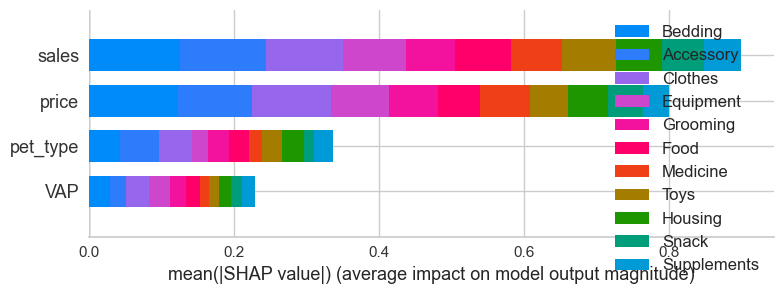

In [ ]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")